In [2]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

Best Params: (5, 50, 0.2, 0.05, 0.08)
Best Total Return: 0.4448
Running backtest with best params: short_ma=5, long_ma=50, profit_pct=0.2, loss_pct=0.05, trailing_stop=0.08


[*********************100%***********************]  1 of 1 completed


   Signal_Date         Action  Exec_Date  Exec_Price_Raw  Exec_Price_eff  \
31  2024-11-04           SELL 2024-11-05      220.772521      220.662135   
32  2024-11-20            BUY 2024-11-21      228.070367      228.184402   
33  2025-01-10  TRAILING STOP 2025-01-13      232.703929      232.587577   
34  2025-02-19            BUY 2025-02-20      244.341910      244.464081   
35  2025-03-04           SELL 2025-03-05      234.845157      234.727734   
36  2025-05-15            BUY 2025-05-16      212.119267      212.225327   
37  2025-05-22      STOP LOSS 2025-05-23      193.450453      193.353727   
38  2025-07-01            BUY 2025-07-02      208.673176      208.777513   
39  2025-08-05           SELL 2025-08-06      205.396898      205.294200   
40  2025-08-06            BUY 2025-08-07      218.631873      218.741189   

    Shares_After    Cash_After  commission  shares_delta  
31      0.000000  14866.443892         1.0    -33.161347  
32     32.575504   7432.221946         1.0   

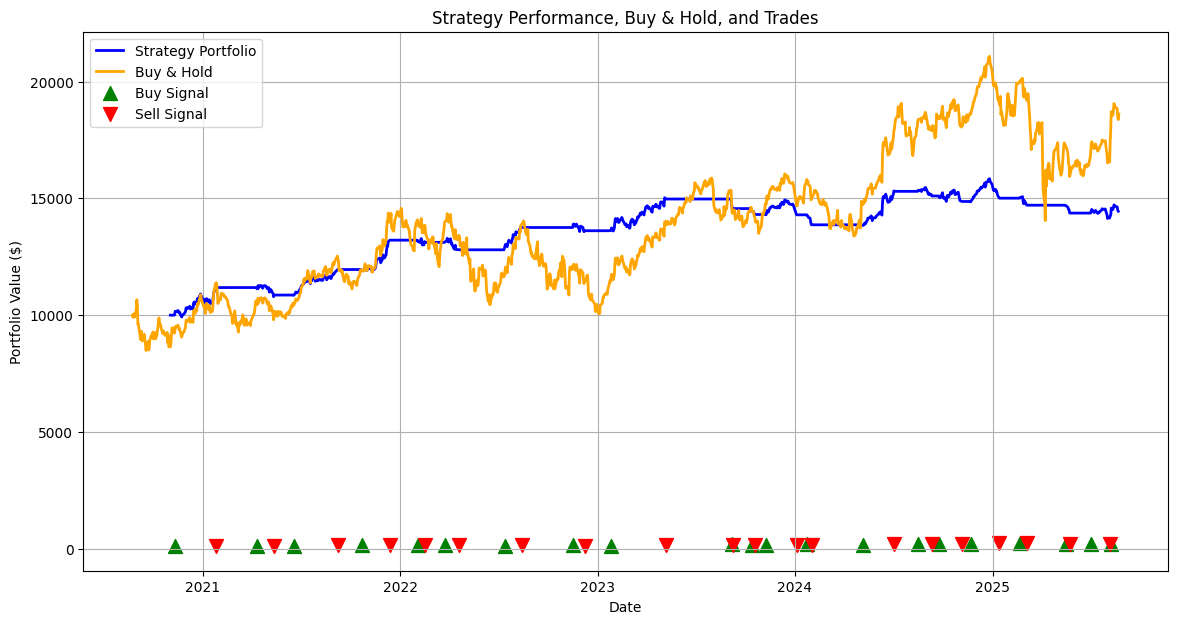

In [8]:
slippage_bps = 0.0005
commission_model = {
    "type": "flat_per_trade",
    "flat_fee":1.00,
    "per_share_fee":0.005,
    "pct_fee":0.0001
}
aloc_frac = 0.50
max_capital_frac = 0.80
vol_target = 0.15
vol_lookback = 45
eps = 1e-12
starting_cash = 10000
period="5y"
ticker = "AAPL"


def effective_price(side, raw_px, slippage_bps=slippage_bps):
    if side == "BUY":
        return raw_px*(1 + slippage_bps)
    elif side == "SELL":
        return raw_px*(1 - slippage_bps)
    else :
        return ValueError("side must be buy or sell")

def commission_value(model, shares, px_eff):
    t = model["type"]
    if t == "flat_per_trade":
        return float(model.get("flat_fee", 0.0))
    elif t == "per_share":
        return float(model.get("per_share_fee", 0.0)) * float(shares)
    elif t == "percent_notional":
        return float(model.get("pct_fee", 0.0)) * float(shares) * float(px_eff)
    else :
        return ValueError("unknown commison model")

def buy_hold(ticker,period=period):
    df_buy_hold = yf.download(ticker, period=period, auto_adjust=True)
    df_buy_hold.columns = [col[0] if isinstance(col, tuple) else col for col in df_buy_hold.columns]
    shares_bh = starting_cash / df_buy_hold["Close"].iloc[0]
    df_buy_hold["BuyHold"] = shares_bh * df_buy_hold["Close"]
    return df_buy_hold
df_buy_hold = buy_hold(ticker)

def run_backtest(ticker, period=period, short_ma = 5, long_ma = 50, profit_pct = 0.2,loss_pct = 0.05, trailing_stop = 0.07):
    # download the data
    df = yf.download(ticker, period=period, auto_adjust=True)
    df.columns = [col[0] if isinstance(col, tuple) else col for col in df.columns]

    # calculate the rolling avg
    df["short_ma"] = df["Close"].rolling(window=short_ma).mean()
    df["long_ma"] = df["Close"].rolling(window=long_ma).mean()
    
    # define the signal
    df["Signal"] = 0
    df.loc[(df["short_ma"] > df["long_ma"]) & (df["short_ma"].shift(1) <= df["long_ma"].shift(1)), "Signal"] = 1  # Buy
    df.loc[(df["long_ma"] > df["short_ma"]) & (df["long_ma"].shift(1) <= df["short_ma"].shift(1)), "Signal"] = -1 # Sell

    # clean and execution price (next day open)
    df = df.dropna(subset=["short_ma", "long_ma"])
    df["ExecPrice"] = df["Open"].shift(-1)
    df = df.dropna(subset=["ExecPrice"])

    # staring portfolio
    cash = starting_cash
    shares_held = 0.0
    portfolio = []
    trades = []
    total_commission_paid = 0.0
    total_slippage_cost = 0.0
    peak_price = 0.0
    entry_price = 0.0

    daily_ret = df["Close"].pct_change()
    #print(daily_ret)
    df["anl_vol"] = daily_ret.rolling(vol_lookback).std() * np.sqrt(252)
    exp_flag = []

    for i in range(len(df)):
        current_price = df["Close"].iloc[i]
        signal = df["Signal"].iloc[i]
        exec_price = df["ExecPrice"].iloc[i]
        
        equity = cash + (shares_held * current_price)
        portfolio.append(equity)

        if shares_held > 0:
            exp_flag.append(1)
        else:
            exp_flag.append(0)

        if shares_held > 0:
            peak_price = (max(peak_price, current_price))

            if current_price <= entry_price*(1 - loss_pct):
                px_eff = effective_price("SELL", exec_price, slippage_bps)
                shares_to_sell = shares_held
                proceeds = shares_to_sell * px_eff
                comm = commission_value(commission_model, shares_to_sell, px_eff)

                cash += proceeds - comm
                shares_held = 0
                total_commission_paid += comm
                total_slippage_cost += (exec_price - px_eff) * shares_to_sell
                shares_delta = -shares_to_sell
                trades.append((df.index[i], "STOP LOSS", df.index[i+1], float(exec_price), px_eff, float(shares_held), float(cash), comm, float(shares_delta)))
                entry_price = 0.0
                peak_price = 0.0
                continue

            elif current_price >= entry_price*(1+profit_pct):
                px_eff = effective_price("SELL", exec_price, slippage_bps)
                shares_to_sell = shares_held
                proceeds = shares_to_sell * px_eff
                comm = commission_value(commission_model, shares_to_sell, px_eff)

                cash += proceeds - comm
                shares_held = 0
                total_commission_paid += comm
                total_slippage_cost += (exec_price - px_eff) * shares_to_sell
                shares_delta = -shares_to_sell
                trades.append((df.index[i], "TAKE PROFIT", df.index[i+1], float(exec_price), px_eff, float(shares_held), float(cash), comm, float(shares_delta)))
                entry_price = 0.0
                peak_price = 0.0
                continue

            elif current_price <= peak_price * (1 - trailing_stop):
                px_eff = effective_price("SELL", exec_price, slippage_bps)
                shares_to_sell = shares_held
                proceeds = shares_to_sell * px_eff
                comm = commission_value(commission_model, shares_to_sell, px_eff)

                cash += proceeds - comm
                shares_held = 0
                total_commission_paid += comm
                total_slippage_cost += (exec_price - px_eff) * shares_to_sell
                shares_delta = -shares_to_sell
                trades.append((df.index[i], "TRAILING STOP", df.index[i+1], float(exec_price), px_eff, float(shares_held), float(cash), comm, float(shares_delta)))
                entry_price = 0.0
                peak_price = 0.0
                continue

    # Buy signal
        if signal == 1:
            fixed_frac = aloc_frac

            vol_today = df["anl_vol"].iloc[i]
            if pd.notna(vol_today) and vol_today > 0:
                vol_frac = vol_target / max(vol_today, eps)
            else :
                vol_frac = fixed_frac
        
            target_frac = min(fixed_frac, vol_frac, max_capital_frac)
            target_value = target_frac * equity
            px_eff = effective_price("BUY", exec_price, slippage_bps)
            target_shares = target_value / px_eff
            shares_delta = max(target_shares - shares_held, 0.0)
            comm = commission_value(commission_model, shares_delta ,px_eff)

            if shares_delta * px_eff + comm > cash:
                shares_delta = max((cash-comm)/px_eff, 0.0)
            if shares_delta == 0.0:
                comm = 0.0
        
            cash -= shares_delta * px_eff + comm
            shares_held += shares_delta
            total_commission_paid += comm
            total_slippage_cost += (px_eff - exec_price) * shares_delta

            trades.append((df.index[i], "BUY", df.index[i+1], float(exec_price), px_eff, float(shares_held), float(cash), comm, float(shares_delta)))
            entry_price = exec_price
            peak_price = exec_price

    
    # Sell signal
        elif signal == -1 and shares_held > 0:
            px_eff = effective_price("SELL", exec_price, slippage_bps)
            shares_to_sell = shares_held
            proceeds = shares_to_sell * px_eff
            comm = commission_value(commission_model, shares_to_sell, px_eff)
        
            cash += proceeds - comm
            shares_held = 0
            total_commission_paid += comm
            total_slippage_cost += (exec_price - px_eff) * shares_to_sell
            shares_delta = -shares_to_sell
            trades.append((df.index[i], "SELL", df.index[i+1], float(exec_price), px_eff, float(shares_held), float(cash), comm, float(shares_delta)))
            entry_price = 0.0
            peak_price = 0.0
    df["Portfolio"] = portfolio
    trades_df = pd.DataFrame(trades, columns=[
    "Signal_Date", "Action", "Exec_Date", "Exec_Price_Raw", "Exec_Price_eff", "Shares_After", "Cash_After", "commission", "shares_delta"
    ])
    #print(df[["Close", "short_ma", "long_ma", "Signal", "Portfolio"]].tail())
    buy_signals = df[df["Signal"] == 1]
    sell_signals = df[df["Signal"] == -1]
        
    return df, trades_df  # for now, just return the prepared frame

df, trades_df = run_backtest(ticker)

def performance_metrics(portfolio_series):
    daily_ret = portfolio_series.pct_change()
    
    # Annualized volatility
    ann_vol = float(daily_ret.std() * np.sqrt(252))
    
    # CAGR
    years = (portfolio_series.index[-1] - portfolio_series.index[0]).days / 365
    cagr = float((portfolio_series.iloc[-1] / portfolio_series.iloc[0])**(1/years) - 1)
    
    # Sharpe ratio
    sharpe = float((daily_ret.mean() * 252) / ann_vol)
    
    # Maximum Drawdown
    cummax = portfolio_series.cummax()
    drawdown = (portfolio_series - cummax) / cummax
    max_dd = float(drawdown.min())
    
    # Total return
    total_return = float(portfolio_series.iloc[-1] / portfolio_series.iloc[0] - 1)
    
    return {
        "Max Drawdown": round(max_dd, 4),
        "Sharpe Ratio": round(sharpe, 4),
        "Annualized Volatility": round(ann_vol, 4),
        "CAGR": round(cagr, 4),
        "Total Return": round(total_return, 4)
    }

bt_metrics = performance_metrics(df["Portfolio"])
bh_metrics = performance_metrics(df_buy_hold["BuyHold"])

#print("Backtest Metrics:", bt_metrics)
#print("Buy & Hold Metrics:", bh_metrics)
#print(df.head())        # DataFrame with portfolio, signals, etc.
#print(trades_df.head()) # DataFrame with executed trades

# finding the bes parameter
short_ma_list = [5, 10, 20, 50]
long_ma_list = [50, 100, 150, 200]
profit_pct_list = [0.1, 0.2, 0.25, 0.3]
loss_pct_list = [0.05, 0.1,0.15, 0.2]
trailing_pct_list = [0.06,0.07,0.08]

best_params = None
best_metric = -np.inf

for s in short_ma_list:
    for l in long_ma_list:
        if s >= l: continue
        for p in profit_pct_list:
            for q in loss_pct_list:
                for t in trailing_pct_list:

                    df_check, trades_check = run_backtest(ticker, short_ma=s, long_ma=l, profit_pct=p, loss_pct=q, trailing_stop=t)
                    metrics = performance_metrics(df_check["Portfolio"])
                    if metrics["Total Return"] > best_metric:
                        best_metric = metrics["Total Return"]
                        best_params = (s, l, p, q, t)

print("Best Params:", best_params)
print("Best Total Return:", best_metric)

s_best, l_best, p_best, q_best, t_best = best_params
print(f"Running backtest with best params: short_ma={s_best}, long_ma={l_best}, "
      f"profit_pct={p_best}, loss_pct={q_best}, trailing_stop={t_best}")

df_best, trades_best = run_backtest(ticker, short_ma=s_best, long_ma=l_best, 
                       profit_pct=p_best, loss_pct=q_best, trailing_stop=t_best)
print(trades_best.tail(10))
print(df_best.tail(10))        
metrics_best = performance_metrics(df_best["Portfolio"])
print("Best Metrics:", metrics_best)
print("Buy & Hold Metrics:", bh_metrics)

plt.figure(figsize=(14,7))

# Main axis: portfolio & buy & hold
plt.plot(df_best.index, df_best["Portfolio"], label="Strategy Portfolio", color="blue", lw=2)
plt.plot(df_buy_hold.index, df_buy_hold["BuyHold"], label="Buy & Hold", color="orange", lw=2)

# Plot trades
buy_trades = trades_best[trades_best["Action"]=="BUY"]
sell_trades = trades_best[trades_best["Action"].isin(["SELL","STOP LOSS","TAKE PROFIT","TRAILING STOP"])]

plt.scatter(buy_trades["Exec_Date"], buy_trades["Exec_Price_eff"], marker="^", color="green", s=100, label="Buy Signal")
plt.scatter(sell_trades["Exec_Date"], sell_trades["Exec_Price_eff"], marker="v", color="red", s=100, label="Sell Signal")
# Labels and legend
#plt.yscale("log")
plt.title("Strategy Performance, Buy & Hold, and Trades")
plt.xlabel("Date")
plt.ylabel("Portfolio Value ($)")
plt.grid(True)

# Combine legends
lines, labels = plt.gca().get_legend_handles_labels()
plt.legend()
plt.show()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Backtest Metrics: {'Max Drawdown': -0.1073, 'Sharpe Ratio': 0.9442, 'Annualized Volatility': 0.0731, 'CAGR': 0.0684, 'Total Return': 0.3735}
Buy & Hold Metrics: {'Max Drawdown': -0.3336, 'Sharpe Ratio': 0.6966, 'Annualized Volatility': 0.284, 'CAGR': 0.1701, 'Total Return': 1.1257}


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

Best Params: (5, 50, 0.2, 0.05, 0.08)
Best Total Return: 0.4307
Trades (tail):
   Signal_Date Action  Exec_Date  Exec_Price_Raw  Exec_Price_eff  \
31  2024-11-04   SELL 2024-11-04      220.772521      220.662135   
32  2024-11-20    BUY 2024-11-20      228.070382      228.184417   
33  2025-01-10   SELL 2025-01-10      232.703929      232.587577   
34  2025-02-19    BUY 2025-02-19      244.341925      244.464096   
35  2025-03-04   SELL 2025-03-04      234.845157      234.727734   
36  2025-05-15    BUY 2025-05-15      212.119267      212.225327   
37  2025-05-22   SELL 2025-05-22      193.450453      193.353727   
38  2025-07-01    BUY 2025-07-01      208.673176      208.777513   
39  2025-08-05   SELL 2025-08-05      205.396898      205.294200   
40  2025-08-06    BUY 2025-08-06      218.631873      218.741189   

    Shares_After    Cash_After  commission  shares_delta  \
31      0.000000  14866.445909         1.0    -33.161351   
32     32.575506   7432.222954         1.0     32.57

Metrics (best): {'Max Drawdown': -0.1073, 'Sharpe Ratio': 1.0541, 'Annualized Volatility': 0.0757, 'CAGR': 0.0797, 'Total Return': 0.4448}
Metrics (Buy&Hold): {'Max Drawdown': -0.3336, 'Sharpe Ratio': 0.6966, 'Annualized Volatility': 0.284, 'CAGR': 0.1701, 'Total Return': 1.1257}


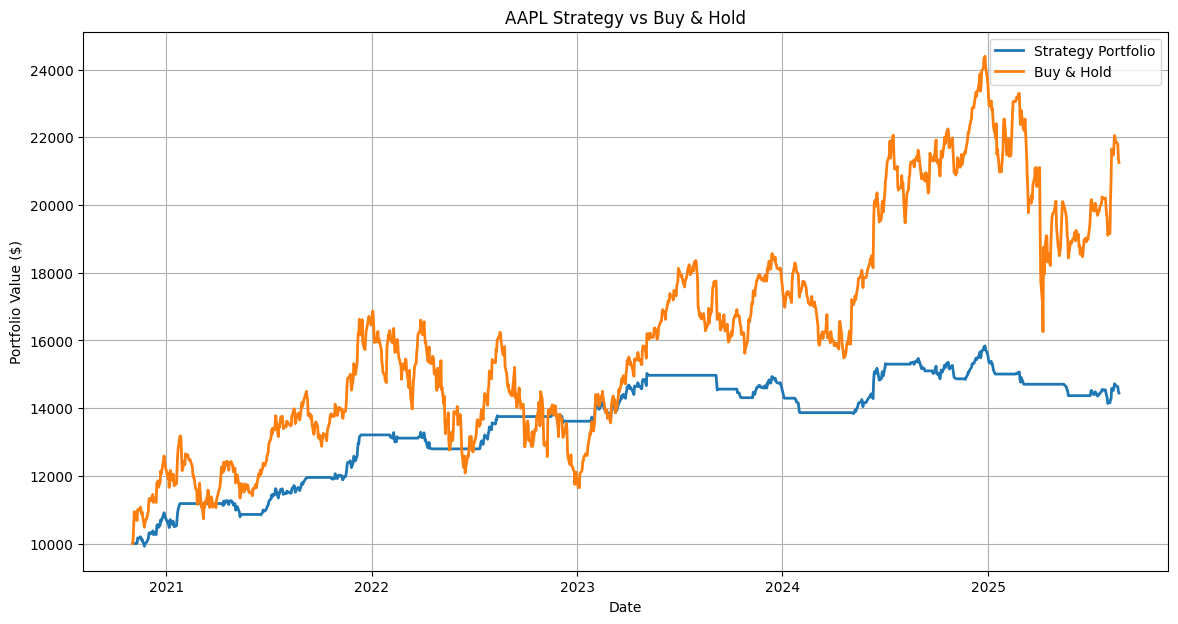

In [7]:
# -----------------------------
# Imports
# -----------------------------
import numpy as np                   # numerical ops
import pandas as pd                 # data frames and time series
import matplotlib.pyplot as plt     # plotting

# yfinance for data (you can swap this out later if desired)
try:
    import yfinance as yf
except ImportError:
    raise ImportError("Please install yfinance: pip install yfinance")

# -----------------------------
# Utility: Performance metrics
# -----------------------------
def performance_metrics(portfolio_series, risk_free=0.0, eps=1e-12):
    """
    Compute standard performance metrics on a portfolio value series.

    Parameters
    ----------
    portfolio_series : pd.Series
        Daily portfolio value (must be indexed by datetime and length >= 2).
    risk_free : float
        Daily risk-free rate (set to 0 for simplicity).
    eps : float
        Small constant for numerical safety.

    Returns
    -------
    dict
    """
    # Guard: ensure we have enough data
    if portfolio_series is None or len(portfolio_series) < 2:
        return {
            "Max Drawdown": np.nan,
            "Sharpe Ratio": np.nan,
            "Annualized Volatility": np.nan,
            "CAGR": np.nan,
            "Total Return": np.nan,
        }

    # Daily returns from portfolio value
    daily_ret = portfolio_series.pct_change().dropna()

    # Annualized volatility (sqrt(252) * daily std)
    ann_vol = float(daily_ret.std() * np.sqrt(252))

    # CAGR = (ending / beginning)^(1/years) - 1
    days = (portfolio_series.index[-1] - portfolio_series.index[0]).days
    years = max(days / 365.25, eps)  # guard against zero division
    cagr = float((portfolio_series.iloc[-1] / max(portfolio_series.iloc[0], eps)) ** (1 / years) - 1)

    # Sharpe ratio = (mean excess return * 252) / ann_vol
    # Here we use risk_free=0 for simplicity
    sharpe = float((daily_ret.mean() * 252) / max(ann_vol, eps))

    # Max drawdown over time
    cummax = portfolio_series.cummax()
    drawdown = (portfolio_series - cummax) / cummax
    max_dd = float(drawdown.min())

    # Total return
    total_return = float(portfolio_series.iloc[-1] / max(portfolio_series.iloc[0], eps) - 1)

    return {
        "Max Drawdown": round(max_dd, 4),
        "Sharpe Ratio": round(sharpe, 4),
        "Annualized Volatility": round(ann_vol, 4),
        "CAGR": round(cagr, 4),
        "Total Return": round(total_return, 4),
    }

# -----------------------------
# Buy & Hold helper
# -----------------------------
def buy_hold_series(close: pd.Series, starting_cash: float):
    """
    Produce a Buy&Hold equity curve aligned to a given Close series.
    We buy at the first Close and hold.

    Parameters
    ----------
    close : pd.Series
    starting_cash : float

    Returns
    -------
    pd.Series : buy & hold equity curve (aligned to 'close' index)
    """
    if len(close) == 0:
        return pd.Series(dtype=float)
    shares = starting_cash / close.iloc[0]           # number of shares we could buy day 1
    return shares * close                            # equity curve over time

# -----------------------------
# Backtester Class
# -----------------------------
class Backtester:
    """
    A class-based, state-machine style backtester with:
      - MA cross signals
      - Volatility targeting + capital constraints
      - Slippage and commissions
      - Stop loss, take profit, trailing stop
    """

    def __init__(
        self,
        ticker: str,
        period: str = "5y",
        starting_cash: float = 10_000.0,
        slippage_bps: float = 0.0005,        # 5 bps = 0.05%
        commission_model: dict = None,       # see below for default
        aloc_frac: float = 0.50,             # fixed fraction of equity cap
        max_capital_frac: float = 0.80,      # never deploy >80% of equity
        vol_target: float = 0.15,            # target annualized vol (15%)
        vol_lookback: int = 45,              # lookback for realized vol (days)
        eps: float = 1e-12                   # numerical guard
    ):
        # ---- store config ----
        self.ticker = ticker
        self.period = period
        self.starting_cash = float(starting_cash)

        self.slippage_bps = float(slippage_bps)
        self.commission_model = commission_model or {
            "type": "flat_per_trade",
            "flat_fee": 1.00,
            "per_share_fee": 0.005,
            "pct_fee": 0.0001
        }

        self.aloc_frac = float(aloc_frac)
        self.max_capital_frac = float(max_capital_frac)
        self.vol_target = float(vol_target)
        self.vol_lookback = int(vol_lookback)
        self.eps = float(eps)

        # ---- runtime state (reset each run) ----
        self.cash = None
        self.shares = None
        self.entry_price = None
        self.peak_price = None
        self.total_commission_paid = None
        self.total_slippage_cost = None

    # ------------- Data prep -------------
    def _download_data(self):
        """
        Download adjusted OHLCV using yfinance and make consistent columns.
        Returns pd.DataFrame with columns: ['Open','High','Low','Close','Adj Close','Volume'].
        """
        df = yf.download(self.ticker, period=self.period, auto_adjust=True)
        # yfinance sometimes returns multi-index columns for multiple tickers; normalize
        df.columns = [c[0] if isinstance(c, tuple) else c for c in df.columns]
        return df

    def _prepare_data(self, short_ma: int, long_ma: int):
        """
        Build the 'engine inputs': MAs, signal, execution price (next open),
        realized volatility for vol targeting.
        """
        # Pull data
        df = self._download_data()

        # Rolling MAs
        df["short_ma"] = df["Close"].rolling(window=short_ma).mean()
        df["long_ma"]  = df["Close"].rolling(window=long_ma).mean()

        # Signal = +1 when short_ma crosses above long_ma; -1 on cross below
        df["Signal"] = 0
        up_cross = (df["short_ma"] > df["long_ma"]) & (df["short_ma"].shift(1) <= df["long_ma"].shift(1))
        dn_cross = (df["long_ma"]  > df["short_ma"]) & (df["long_ma"].shift(1)  <= df["short_ma"].shift(1))
        df.loc[up_cross, "Signal"] = 1
        df.loc[dn_cross, "Signal"] = -1

        # Drop rows until both MAs exist
        df = df.dropna(subset=["short_ma", "long_ma"])

        # Execution price is next day's open: shift(-1)
        # After shifting, last row has NaN => drop it (can't execute on next open)
        df["ExecPrice"] = df["Open"].shift(-1)
        df = df.dropna(subset=["ExecPrice"])

        # Realized annualized volatility using rolling window on close-to-close returns
        daily_ret = df["Close"].pct_change()
        df["anl_vol"] = daily_ret.rolling(self.vol_lookback).std() * np.sqrt(252)

        # Precompute Buy & Hold on the SAME index (aligned)
        df["BuyHold"] = buy_hold_series(df["Close"], self.starting_cash)

        return df

    # ------------- Microstructure helpers -------------
    def _effective_price(self, side: str, raw_px: float) -> float:
        """
        Apply slippage to a raw execution price (next day open).
        BUY pays up, SELL receives less.
        """
        if side.upper() == "BUY":
            return float(raw_px) * (1 + self.slippage_bps)
        elif side.upper() == "SELL":
            return float(raw_px) * (1 - self.slippage_bps)
        else:
            raise ValueError("side must be 'BUY' or 'SELL'")

    def _commission_value(self, shares: float, px_eff: float) -> float:
        """
        Compute commission cost given the configured model.
        Supports:
          - 'flat_per_trade': pay flat_fee each trade
          - 'per_share': pay per_share_fee * shares
          - 'percent_notional': pay pct_fee * shares * px_eff
        """
        t = self.commission_model.get("type", "flat_per_trade")
        if t == "flat_per_trade":
            return float(self.commission_model.get("flat_fee", 0.0))
        elif t == "per_share":
            return float(self.commission_model.get("per_share_fee", 0.0)) * float(shares)
        elif t == "percent_notional":
            return float(self.commission_model.get("pct_fee", 0.0)) * float(shares) * float(px_eff)
        else:
            raise ValueError(f"Unknown commission model: {t}")

    # ------------- Trade execution helpers -------------
    def _enter_long(self, exec_price_raw: float, timestamp, trades, equity, vol_today):
        """
        Enter/resize long position using volatility targeting and capital caps.
        Creates a BUY trade if it increases shares.
        """
        # Decide target fraction of equity to deploy: min of fixed, vol-based, and cap
        fixed_frac = self.aloc_frac
        if pd.notna(vol_today) and vol_today > 0:
            vol_frac = self.vol_target / max(vol_today, self.eps)     # lower realized vol -> more allocation
        else:
            vol_frac = fixed_frac

        target_frac = min(fixed_frac, vol_frac, self.max_capital_frac)  # cap to avoid over-deploy
        target_value = target_frac * equity                              # target notional to deploy

        # Compute target shares at effective BUY price
        px_eff = self._effective_price("BUY", exec_price_raw)
        target_shares = target_value / max(px_eff, self.eps)

        # We only BUY additional shares if target_shares > current shares
        shares_delta = max(target_shares - self.shares, 0.0)
        if shares_delta <= 0:
            return  # already at/above target; do nothing

        # Commission for the new shares
        comm = self._commission_value(shares_delta, px_eff)

        # Cash constraint: ensure we can pay for shares + commission
        if shares_delta * px_eff + comm > self.cash:
            shares_delta = max((self.cash - comm) / max(px_eff, self.eps), 0.0)
            if shares_delta <= 0:
                return  # cannot afford any shares after commission
            # recompute commission for actual shares to be bought (optional: keep flat commission)
            comm = self._commission_value(shares_delta, px_eff)

        # Execute: pay cash, increase shares
        self.cash -= shares_delta * px_eff + comm
        self.shares += shares_delta

        # Slippage cost = (price paid - raw exec) * shares
        self.total_commission_paid += comm
        self.total_slippage_cost += (px_eff - exec_price_raw) * shares_delta

        # First fill sets entry & peak
        if self.entry_price is None or self.shares == shares_delta:
            self.entry_price = exec_price_raw
            self.peak_price = exec_price_raw

        # Log trade
        trades.append({
            "Signal_Date": timestamp,                 # date we decided
            "Action": "BUY",
            "Exec_Date": timestamp,                   # executing at next open already aligned
            "Exec_Price_Raw": float(exec_price_raw),
            "Exec_Price_eff": float(px_eff),
            "Shares_After": float(self.shares),
            "Cash_After": float(self.cash),
            "commission": float(comm),
            "shares_delta": float(shares_delta),
            "reason": "Entry/Resize via vol-targeting"
        })

    def _exit_position(self, exec_price_raw: float, timestamp, trades, reason: str):
        """
        Close the entire long position at effective SELL price.
        """
        if self.shares <= 0:
            return  # nothing to exit

        # SELL all
        px_eff = self._effective_price("SELL", exec_price_raw)
        shares_to_sell = self.shares
        proceeds = shares_to_sell * px_eff
        comm = self._commission_value(shares_to_sell, px_eff)

        # Receive cash, zero shares
        self.cash += proceeds - comm
        self.shares = 0.0

        # Slippage/commission accounting
        self.total_commission_paid += comm
        self.total_slippage_cost += (exec_price_raw - px_eff) * shares_to_sell

        # Reset entry/peak
        self.entry_price = None
        self.peak_price = None

        # Log trade
        trades.append({
            "Signal_Date": timestamp,
            "Action": "SELL",
            "Exec_Date": timestamp,
            "Exec_Price_Raw": float(exec_price_raw),
            "Exec_Price_eff": float(px_eff),
            "Shares_After": float(self.shares),
            "Cash_After": float(self.cash),
            "commission": float(comm),
            "shares_delta": float(-shares_to_sell),
            "reason": reason
        })

    def _check_exit_conditions(self, current_price: float, exec_price_raw: float, timestamp, trades,
                               profit_pct: float, loss_pct: float, trailing_stop: float):
        """
        If in a position, check stop-loss / take-profit / trailing-stop and exit if triggered.
        """
        # Update peak while holding
        self.peak_price = max(self.peak_price, current_price)

        # 1) Hard stop-loss
        if current_price <= (self.entry_price * (1 - loss_pct)):
            self._exit_position(exec_price_raw, timestamp, trades, reason="STOP LOSS")
            return True

        # 2) Take-profit
        if current_price >= (self.entry_price * (1 + profit_pct)):
            self._exit_position(exec_price_raw, timestamp, trades, reason="TAKE PROFIT")
            return True

        # 3) Trailing stop from the running peak
        if current_price <= (self.peak_price * (1 - trailing_stop)):
            self._exit_position(exec_price_raw, timestamp, trades, reason="TRAILING STOP")
            return True

        return False  # no exit triggered

    # ------------- Main run -------------
    def run(self, short_ma: int, long_ma: int, profit_pct: float, loss_pct: float, trailing_stop: float):
        """
        Run a single backtest with the provided parameters.
        Returns
        -------
        df : pd.DataFrame  (includes Portfolio and BuyHold columns)
        trades_df : pd.DataFrame (trade blotter)
        """
        # Prepare inputs/signals/features
        df = self._prepare_data(short_ma, long_ma)

        # Reset state
        self.cash = float(self.starting_cash)
        self.shares = 0.0
        self.entry_price = None
        self.peak_price = None
        self.total_commission_paid = 0.0
        self.total_slippage_cost = 0.0

        # Storage
        portfolio = []   # equity per day
        exposure = []    # 1 if in market, 0 otherwise
        trades = []      # trade logs

        # Iterate day by day (state machine)
        for i in range(len(df)):
            ts = df.index[i]                     # timestamp for the row
            current_price = df["Close"].iloc[i]  # today's close (for marking equity & peak checks)
            exec_price = df["ExecPrice"].iloc[i] # next day open (already aligned)
            signal = int(df["Signal"].iloc[i])   # +1, 0, -1
            vol_today = df["anl_vol"].iloc[i]    # realized annualized vol

            # Mark-to-market today's equity (before any exec on next open)
            equity = self.cash + self.shares * current_price
            portfolio.append(equity)
            exposure.append(1 if self.shares > 0 else 0)

            # If holding, first check exits (they execute at 'exec_price')
            if self.shares > 0:
                exited = self._check_exit_conditions(
                    current_price=current_price,
                    exec_price_raw=exec_price,
                    timestamp=ts,
                    trades=trades,
                    profit_pct=profit_pct,
                    loss_pct=loss_pct,
                    trailing_stop=trailing_stop
                )
                if exited:
                    # After exit, we won't process entry signal in the same bar
                    continue

            # If not exited, consider MA entry/exit signals
            if signal == 1:
                # Enter/resize long using vol targeting (exec at 'exec_price')
                self._enter_long(exec_price, ts, trades, equity, vol_today)
            elif signal == -1 and self.shares > 0:
                # Flat on crossdown
                self._exit_position(exec_price, ts, trades, reason="MA Crossdown")

        # Attach results to df
        df["Portfolio"] = pd.Series(portfolio, index=df.index)
        df["Exposure"] = pd.Series(exposure, index=df.index)

        # Trades as DataFrame
        trades_df = pd.DataFrame(trades)

        return df, trades_df

# -----------------------------
# Parameter Optimization
# -----------------------------
def optimize_parameters(
    ticker: str,
    period: str,
    starting_cash: float,
    grid_short_ma,
    grid_long_ma,
    grid_profit_pct,
    grid_loss_pct,
    grid_trailing_pct,
    # Risk & costs (keep consistent across runs)
    slippage_bps=0.0005,
    commission_model=None,
    aloc_frac=0.50,
    max_capital_frac=0.80,
    vol_target=0.15,
    vol_lookback=45,
    eps=1e-12
):
    """
    Brute-force grid search for best Total Return.
    Returns best_params, best_metric, and a DataFrame of all trials.
    """
    # Reuse a single Backtester instance for speed (fresh state each run)
    bt = Backtester(
        ticker=ticker,
        period=period,
        starting_cash=starting_cash,
        slippage_bps=slippage_bps,
        commission_model=commission_model,
        aloc_frac=aloc_frac,
        max_capital_frac=max_capital_frac,
        vol_target=vol_target,
        vol_lookback=vol_lookback,
        eps=eps
    )

    results = []
    best_metric = -np.inf
    best_params = None

    for s in grid_short_ma:
        for l in grid_long_ma:
            if s >= l:
                continue   # ensure a proper short<long MA pair
            for p in grid_profit_pct:
                for q in grid_loss_pct:
                    for t in grid_trailing_pct:
                        # Run backtest with this param set
                        df, _ = bt.run(short_ma=s, long_ma=l, profit_pct=p, loss_pct=q, trailing_stop=t)

                        # Evaluate
                        metrics = performance_metrics(df["Portfolio"])
                        total_ret = metrics["Total Return"]

                        # Store result row
                        results.append({
                            "short_ma": s, "long_ma": l,
                            "profit_pct": p, "loss_pct": q, "trailing_stop": t,
                            "Total Return": total_ret
                        })

                        # Track the best
                        if total_ret > best_metric:
                            best_metric = total_ret
                            best_params = (s, l, p, q, t)

    results_df = pd.DataFrame(results).sort_values("Total Return", ascending=False).reset_index(drop=True)
    return best_params, best_metric, results_df

# -----------------------------
# Example usage
# -----------------------------
if __name__ == "__main__":
    # ---- Configuration ----
    ticker = "AAPL"
    period = "5y"
    starting_cash = 10_000

    # Instantiate a backtester (keep costs and risk the same across runs)
    bt = Backtester(
        ticker=ticker,
        period=period,
        starting_cash=starting_cash,
        slippage_bps=0.0005,
        commission_model={
            "type": "flat_per_trade",
            "flat_fee": 1.00,
            "per_share_fee": 0.005,
            "pct_fee": 0.0001
        },
        aloc_frac=0.50,
        max_capital_frac=0.80,
        vol_target=0.15,
        vol_lookback=45,
    )

    # ---- Single run ----
    df, trades = bt.run(short_ma=5, long_ma=50, profit_pct=0.20, loss_pct=0.05, trailing_stop=0.07)

    # Metrics
    bt_metrics = performance_metrics(df["Portfolio"])
    bh_metrics = performance_metrics(df["BuyHold"])
    print("Backtest Metrics:", bt_metrics)
    print("Buy & Hold Metrics:", bh_metrics)

    # ---- Parameter search (simple grid) ----
    short_ma_list = [5, 10, 20, 50]
    long_ma_list = [50, 100, 150, 200]
    profit_pct_list = [0.10, 0.20, 0.25, 0.30]
    loss_pct_list = [0.05, 0.10, 0.15, 0.20]
    trailing_pct_list = [0.06, 0.07, 0.08]

    best_params, best_metric, results_df = optimize_parameters(
        ticker=ticker,
        period=period,
        starting_cash=starting_cash,
        grid_short_ma=short_ma_list,
        grid_long_ma=long_ma_list,
        grid_profit_pct=profit_pct_list,
        grid_loss_pct=loss_pct_list,
        grid_trailing_pct=trailing_pct_list,
        slippage_bps=0.0010,
        commission_model={
            "type": "flat_per_trade",
            "flat_fee": 1.00,
            "per_share_fee": 0.005,
            "pct_fee": 0.0001
        },
        aloc_frac=0.50,
        max_capital_frac=0.80,
        vol_target=0.15,
        vol_lookback=45
    )

    print("Best Params:", best_params)
    print("Best Total Return:", best_metric)

    # ---- Re-run with best params on the same period (for demo) ----
    if best_params is not None:
        s_best, l_best, p_best, q_best, t_best = best_params
        df_best, trades_best = bt.run(
            short_ma=s_best, long_ma=l_best,
            profit_pct=p_best, loss_pct=q_best, trailing_stop=t_best
        )
        print("Trades (tail):")
        print(trades_best.tail(10))
        print("Metrics (best):", performance_metrics(df_best["Portfolio"]))
        print("Metrics (Buy&Hold):", performance_metrics(df_best["BuyHold"]))

        # ---- Plot ----
        plt.figure(figsize=(14, 7))
        plt.plot(df_best.index, df_best["Portfolio"], label="Strategy Portfolio", lw=2)
        plt.plot(df_best.index, df_best["BuyHold"], label="Buy & Hold", lw=2)
        plt.title(f"{ticker} Strategy vs Buy & Hold")
        plt.xlabel("Date")
        plt.ylabel("Portfolio Value ($)")
        plt.grid(True)
        plt.legend()
        plt.show()
